In [18]:
# !pip install matplotlib

In [19]:
# !pip install tensorflow-gpu

In [3]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

/userhome/30/magarwal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/userhome/30/magarwal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/userhome/30/magarwal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/userho

1.14.0


True

In [20]:
# !pip install sklearn

In [21]:
# !pip install Pillow

In [22]:
# !pip install tqdm

In [20]:
!pip install gast==0.2.2

Processing ./.cache/pip/wheels/19/a7/b9/0740c7a3a7d1d348f04823339274b90de25fbcd217b2ee1fbe/gast-0.2.2-py3-none-any.whl
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2017.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2017/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [3]:
# Read the json file
annotation_file = './annotations/captions_train2017.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in lists
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [4]:
# Select the first 80000 captions from the shuffled set
num_examples = 80000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
len(train_captions), len(img_name_vector)

(80000, 80000)

In [5]:
#Loading the weights of the InceptionV3 imagenet model without including the fully connected layers
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape =(299, 299, 3))

#setting this model as input and its last layer as hidden layer and finally passing it to keras model
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
print(image_features_extract_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
def load_image(image_path):
    #Reading the image from image path
    img = tf.io.read_file(image_path)
    
    #Decoding it to jpeg format with 3 channels
    img = tf.image.decode_jpeg(img, channels=3)
    
    #Resizing it to shape of 299px*299px
    img = tf.image.resize(img, (299, 299))
    
    #Converting the pixels into range -1 to 1
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [10]:
import math
BATCH_SIZE = 16
    
#Get unique images
encode_train = sorted(set(img_name_vector))

#Creating a dataset with a separate element for each row of the input tensor
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

#Make batches
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

for img, path in tqdm(image_dataset, total = math.ceil(len(encode_train)/BATCH_SIZE)):
    
  #Obtain batch feature maps using the pre-trained weights of the keras model  
  batch_features = image_features_extract_model(img)
    
  #Reshape each tensor in the batch to 64x2048  
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    
  #Saving the feature maps on disk  
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 7393/7393 [55:15<00:00,  2.23it/s]  


'1. Getting all the unique image.\n2. Creating a dataset with a separate element for each row of the input tensor.\n3. Maps map_func across batch_size consecutive elements of this dataset and then combines them into a batch. Functionally, it is equivalent to map followed by batch.\n4. Extracting the features and reshaping it and finally saving the model.'

In [7]:
# Choose the top 8000 words for the vocabulary
top_k = 8000

# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
  return max(len(t) for t in tensor)
             
#Tokenize the captions    
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

#Create the tokenized sequences
train_seqs = tokenizer.texts_to_sequences(train_captions)

#Calculates the max_length
max_length = calc_max_length(train_seqs)

#Post pad each sequence to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')          

In [8]:
#Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(64000, 64000, 16000, 16000)

In [9]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [10]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [11]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [13]:
vocab_size

8001

In [14]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_name, img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [17]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [34]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [30]:
!dir "./checkpoints/ep50"

ckpt-9.data-00000-of-00002  ckpt-9.data-00001-of-00002	ckpt-9.index


In [18]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
start_epoch = 0
loss_plot = []

In [19]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [20]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    if epoch % 10 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 2.0785
Epoch 1 Batch 100 Loss 1.0569
Epoch 1 Batch 200 Loss 1.0848
Epoch 1 Batch 300 Loss 0.9449
Epoch 1 Batch 400 Loss 0.8747
Epoch 1 Batch 500 Loss 0.8353
Epoch 1 Batch 600 Loss 0.7084
Epoch 1 Batch 700 Loss 0.7676
Epoch 1 Batch 800 Loss 0.6627
Epoch 1 Batch 900 Loss 0.7401
Epoch 1 Loss 0.890065
Time taken for 1 epoch 1860.5960512161255 sec

Epoch 2 Batch 0 Loss 0.7597
Epoch 2 Batch 100 Loss 0.6845
Epoch 2 Batch 200 Loss 0.8097
Epoch 2 Batch 300 Loss 0.7305
Epoch 2 Batch 400 Loss 0.7131
Epoch 2 Batch 500 Loss 0.7021
Epoch 2 Batch 600 Loss 0.6058
Epoch 2 Batch 700 Loss 0.6659
Epoch 2 Batch 800 Loss 0.5958
Epoch 2 Batch 900 Loss 0.6692
Epoch 2 Loss 0.704133
Time taken for 1 epoch 701.821676492691 sec

Epoch 3 Batch 0 Loss 0.6827
Epoch 3 Batch 100 Loss 0.6298
Epoch 3 Batch 200 Loss 0.7400
Epoch 3 Batch 300 Loss 0.6683
Epoch 3 Batch 400 Loss 0.6534
Epoch 3 Batch 500 Loss 0.6

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

NameError: name 'loss_plot' is not defined

In [17]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [18]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a clock tower built in the center of a pathway in a park <end>
Prediction Caption: a building with a clock tower <end>


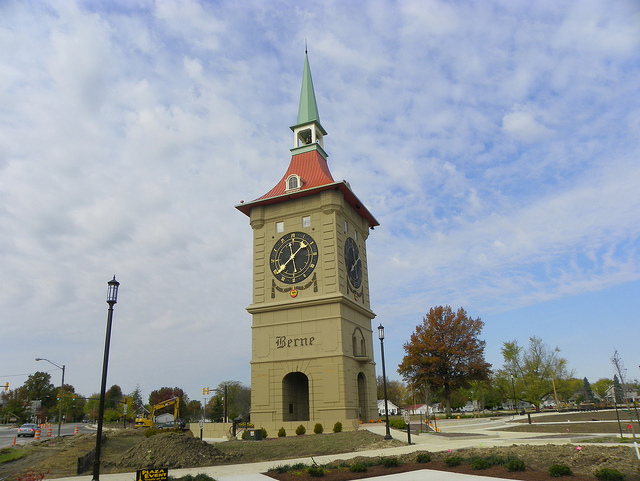

In [127]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
#rid = 655
#print(rid)
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
# opening the image
Image.open(image)

Prediction Caption: three children are eating hotdogs nearby and a lunch <end>


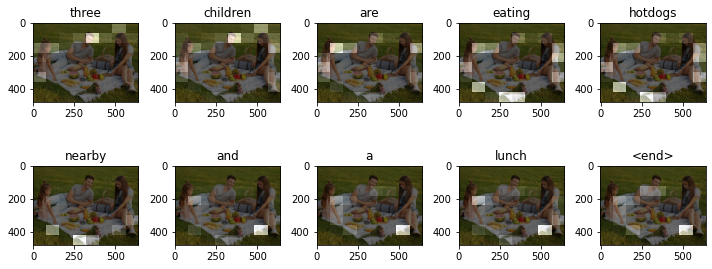

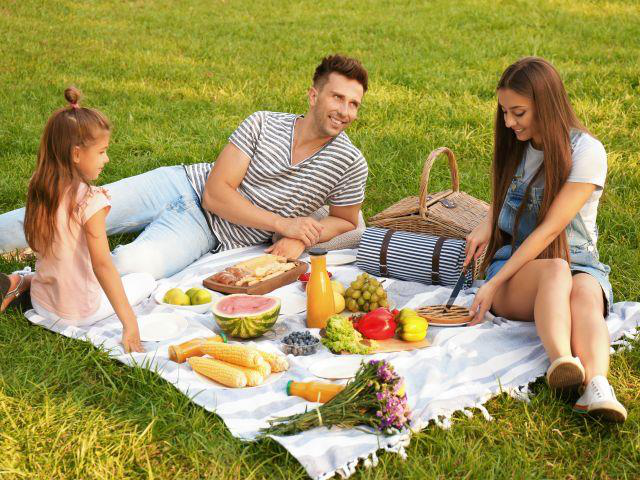

In [191]:
image_path = './picnic.jpg'
#image_extension = image_url[-4:]
#image_path = tf.keras.utils.get_file('image'+image_extension,origin=image_url)
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [23]:
test_steps = len(img_name_val) // BATCH_SIZE
testset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
testset = testset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.string, tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
testset = testset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
testset = testset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [24]:
def evaluate_all(img_name, img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    
    result = []
    for name in img_name:
        result.append([int(name.numpy().decode('utf-8').split('/')[-1].replace('.jpg','').lstrip('0'))])
    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions, 1).numpy()
        for ix in range(len(predicted_id)):
            if result[ix][-1] != '<end>':
                result[ix].append(tokenizer.index_word[predicted_id[ix]])
        loss += loss_function(target[:, i], predictions)
        dec_input = tf.expand_dims(tf.argmax(predictions, 1), 1)
    
    for ix in range(len(result)):
        if '<end>' in result[ix]:
            result[ix].remove('<end>')
    results = []
    for r in result:
        name = r[0]
        caption = ""
        for c in range(1, len(r)):
            caption += r[c]
            if c != len(r) - 1:
                caption += " "
        results.append({'image_id': name, 'caption': caption})
        
    total_loss = (loss / int(target.shape[1]))
    
    return results, loss, total_loss

In [100]:
test_loss = 0
results = []
img_ids = []
for (batch, (img_name, img_tensor, target)) in enumerate(testset):
    result, batch_loss, t_loss = evaluate_all(img_name, img_tensor, target)
    for r in  result:
        if r['image_id'] not in img_ids:
            results.append(r)
            img_ids.append(r['image_id'])
    test_loss += t_loss

    if batch % 100 == 0:
        print ('Batch {} Loss {:.4f}'.format(batch, batch_loss.numpy() / int(target.shape[1])))
        
test_loss_plot = test_loss / test_steps

print ('Loss {:.6f}'.format(test_loss_plot))

Batch 0 Loss 2.0846
Batch 100 Loss 1.9001
Batch 200 Loss 2.1047
Loss 2.031180


In [101]:
import json
with open('./results/captions_train2017_20ep_results.json', 'w') as f:
    json.dump(results, f)

In [112]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [113]:
checkpoint.restore("./checkpoints/train/ckpt-2")

In [59]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pycocoevalcap.eval import COCOEvalCap
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [27]:
import imp
import pycocoevalcap.eval
import pycocoevalcap.tokenizer
imp.reload(pycocoevalcap.eval) 
imp.reload(pycocoevalcap.tokenizer)
from pycocoevalcap.eval import COCOEvalCap

In [102]:
# set up file names and pathes
dataDir='.'
dataType='train2017'
algName = '20ep'
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
subtypes=['results', 'evalImgs', 'eval']
[resFile, evalImgsFile, evalFile]= \
['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType,algName,subtype) for subtype in subtypes]
    
# download Stanford models
!./get_stanford_models.sh

Found Stanford CoreNLP.


In [103]:
# create coco object and cocoRes object
coco = COCO(annFile)
cocoRes = coco.loadRes(resFile)

loading annotations into memory...
Done (t=1.36s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!


In [104]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 160594, 'reflen': 142304, 'guess': [160594, 145381, 130170, 114963], 'correct': [73115, 29585, 10243, 3501]}
ratio: 1.128527659096012
Bleu_1: 0.455
Bleu_2: 0.304
Bleu_3: 0.194
Bleu_4: 0.122
computing METEOR score...
METEOR: 0.163
computing Rouge score...
ROUGE_L: 0.397
computing CIDEr score...
CIDEr: 0.432
computing SPICE score...
SPICE: 0.110


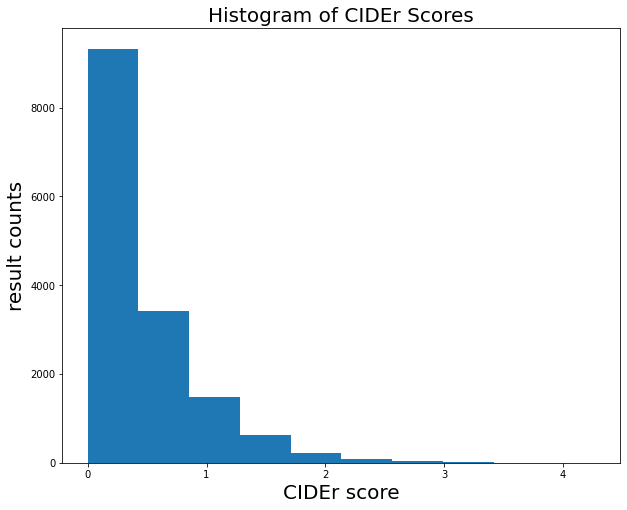

In [105]:
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [106]:
ciders = [0, 0.484, 0.524, 0.451, 0.432, 0.436]
bleus = [0, 0.456, 0.519, 0.454, 0.455, 0.447]
meteors = [0, 0.169, 0.177, 0.169, 0.163, 0.166]
rouges = [0, 0.429, 0.435, 0.404, 0.397, 0.395]
spices = [0, 0.115, 0.121, 0.116, 0.110, 0.112]
loss = [1.326048, 1.533952, 1.768272, 2.031180, 2.324567]

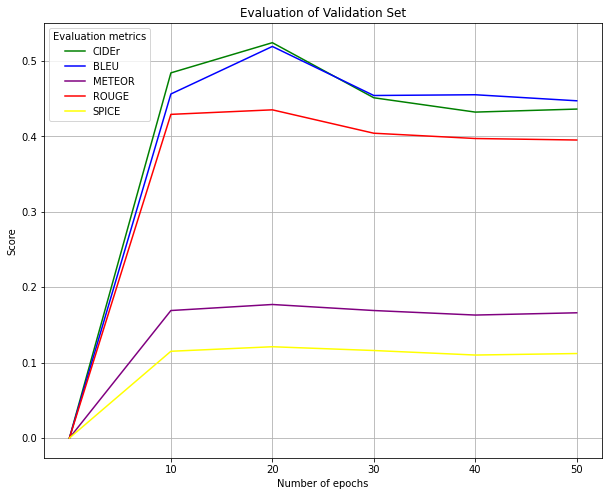

In [107]:
plt.plot(ciders, label='CIDEr', color='green')
plt.plot(bleus, label='BLEU', color='blue')
plt.plot(meteors, label='METEOR', color='purple')
plt.plot(rouges, label='ROUGE', color='red')
plt.plot(spices, label='SPICE', color='yellow')
plt.legend(loc='best', title='Evaluation metrics')
plt.xlabel("Number of epochs")
plt.ylabel("Score")
plt.title("Evaluation of Validation Set")
plt.xticks([1, 2, 3, 4, 5], [10, 20, 30, 40, 50])
plt.grid()
plt.show()

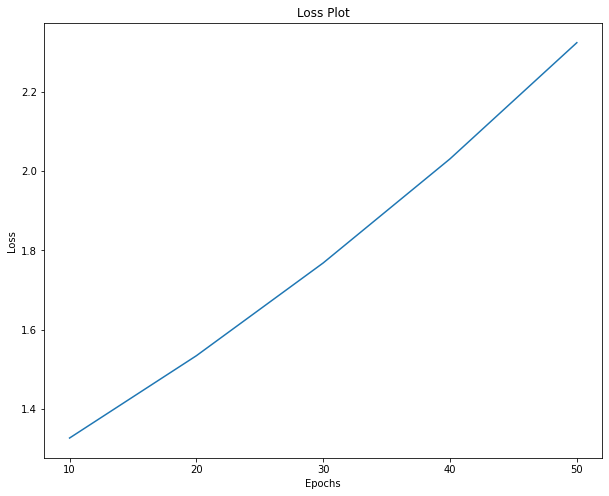

In [110]:
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.xticks([0, 1, 2, 3, 4], [10, 20, 30, 40, 50])
plt.show()